In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import sys
import pickle

sys.path.append('../scripts')
from helpers import create_model

from sklearn.model_selection import train_test_split, KFold

sns.set()

2022-10-22 18:48:19.884070: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-22 18:48:19.994325: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-10-22 18:48:19.998431: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/olivier/miniconda3/lib:/home/olivier/miniconda3/lib:
2022-10-22 18:48:19.998441: I tensorf

## Load data

In [2]:
with open('../data/presidentielle.pkl', 'rb') as f:
    data = pickle.load(f)

df1 = data['df1']
df2 = data['df2']

prop1 = data['prop1']
prop2 = data['prop2']

colnames = data['colnames']

del data

## Choosing a model

We will use k-fold cross-validation to identify the number of layers and neurons per layer. We first define a function that allows us to create a neural network using TensorFlow.

We now set the hyperparameters of the model that we will be testing. 

- `hidden_shape` is the number of neurons per layer
- `hidden_n_layer` is the number of hidden layers

In [3]:
model_params = np.meshgrid(
    [5, 20, 50],
    [1, 3, 5],
    [False]
)
model_params = np.array(model_params).T.reshape(-1, 3)
model_params = pd.DataFrame(
    model_params,
    columns=["hidden_shape", "hidden_n_layers", "batch_norm"])
model_params

,hidden_shape,hidden_n_layers,batch_norm
0,5,1,0
1,5,3,0
2,5,5,0
3,20,1,0
4,20,3,0
5,20,5,0
6,50,1,0
7,50,3,0
8,50,5,0


We now run the 5-fold cross-validation.

In [4]:
train_prop1, test_prop1, train_prop2, test_prop2 = train_test_split(
    prop1, prop2, test_size=.2, random_state=63)

nkf = 5
results = np.zeros((model_params.shape[0], nkf))
kf = KFold(nkf, random_state=63, shuffle=True)

for kf_idx, (train_idx, val_idx) in enumerate(kf.split(train_prop1)):
    for param_idx in range(model_params.shape[0]):

        hidden_shape = model_params["hidden_shape"][param_idx]
        hidden_n_layers = model_params["hidden_n_layers"][param_idx]
        batch_norm = model_params["batch_norm"][param_idx]

        model = create_model(
            input_shape=prop1.shape[1],
            output_shape=prop2.shape[1],
            hidden_shape=hidden_shape,
            hidden_n_layers=hidden_n_layers,
            batch_norm=batch_norm)

        model.fit(
            x=train_prop1.iloc[train_idx, :],
            y=train_prop2.iloc[train_idx, :],
            epochs=10,
            verbose=0)

        error = model.evaluate(
            x=train_prop1.iloc[val_idx, :],
            y=train_prop2.iloc[val_idx, :],
            verbose=0)
        results[param_idx, kf_idx] = error

        print(f'{kf_idx=}, {param_idx=} {error=:.4f}')


2022-10-22 18:48:21.209710: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/olivier/miniconda3/lib:/home/olivier/miniconda3/lib:
2022-10-22 18:48:21.209729: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2022-10-22 18:48:21.209743: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (pop-os): /proc/driver/nvidia/version does not exist
2022-10-22 18:48:21.209939: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


kf_idx=0, param_idx=0 error=0.0034
kf_idx=0, param_idx=1 error=0.0033
kf_idx=0, param_idx=2 error=0.0033
kf_idx=0, param_idx=3 error=0.0033
kf_idx=0, param_idx=4 error=0.0031
kf_idx=0, param_idx=5 error=0.0034
kf_idx=0, param_idx=6 error=0.0032
kf_idx=0, param_idx=7 error=0.0032
kf_idx=0, param_idx=8 error=0.0035
kf_idx=1, param_idx=0 error=0.0033
kf_idx=1, param_idx=1 error=0.0032
kf_idx=1, param_idx=2 error=0.0032
kf_idx=1, param_idx=3 error=0.0033
kf_idx=1, param_idx=4 error=0.0032
kf_idx=1, param_idx=5 error=0.0031
kf_idx=1, param_idx=6 error=0.0032
kf_idx=1, param_idx=7 error=0.0033
kf_idx=1, param_idx=8 error=0.0032
kf_idx=2, param_idx=0 error=0.0032
kf_idx=2, param_idx=1 error=0.0032
kf_idx=2, param_idx=2 error=0.0035
kf_idx=2, param_idx=3 error=0.0033
kf_idx=2, param_idx=4 error=0.0032
kf_idx=2, param_idx=5 error=0.0033
kf_idx=2, param_idx=6 error=0.0032
kf_idx=2, param_idx=7 error=0.0033
kf_idx=2, param_idx=8 error=0.0033
kf_idx=3, param_idx=0 error=0.0033
kf_idx=3, param_idx=

We look at the distribution of errors for each model. There does not seem to be a significant difference in terms of prediction error between the models.

<AxesSubplot: xlabel='param_index', ylabel='value'>

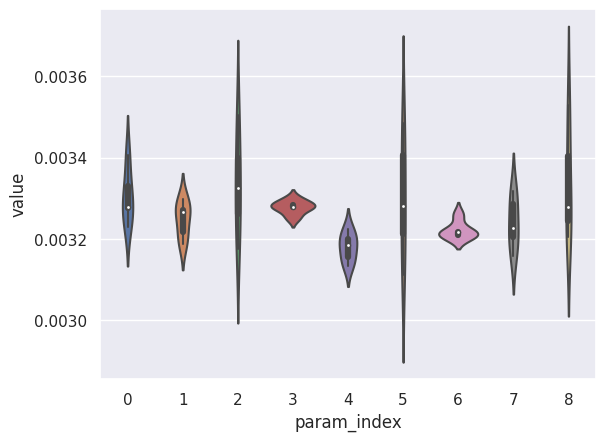

In [5]:
model_params_results = pd.concat([model_params, pd.DataFrame(results)], axis=1)
model_params_results["param_index"] = range(model_params_results.shape[0])

model_params_results_melt = model_params_results.melt(
    id_vars=list(model_params.columns)+["param_index"])

sns.violinplot(model_params_results_melt, x="param_index", y="value")

We look at the median error for each model. We that 3 layers with 20 neurons per layer seem to give the best results.

In [6]:
(model_params_results_melt
    .groupby(list(model_params.columns))["value"]
    .median()
    .sort_values())

hidden_shape  hidden_n_layers  batch_norm
20            3                0             0.003186
50            1                0             0.003217
              3                0             0.003226
5             3                0             0.003268
20            1                0             0.003278
50            5                0             0.003279
5             1                0             0.003279
20            5                0             0.003282
5             5                0             0.003326
Name: value, dtype: float64

## Estimating test error

We now estimate the test error of this model.

In [10]:
model = create_model(
    input_shape=prop1.shape[1],
    output_shape=prop2.shape[1],
    hidden_shape=20,
    hidden_n_layers=3,
    batch_norm=False)
    
history = model.fit(
    x=train_prop1, 
    y=train_prop2,
    epochs=50, 
    validation_split=.1,
    verbose=0)

In [11]:
model.evaluate(
    x=test_prop1,
    y=test_prop2,
    verbose=0)

0.003008913015946746

<AxesSubplot: >

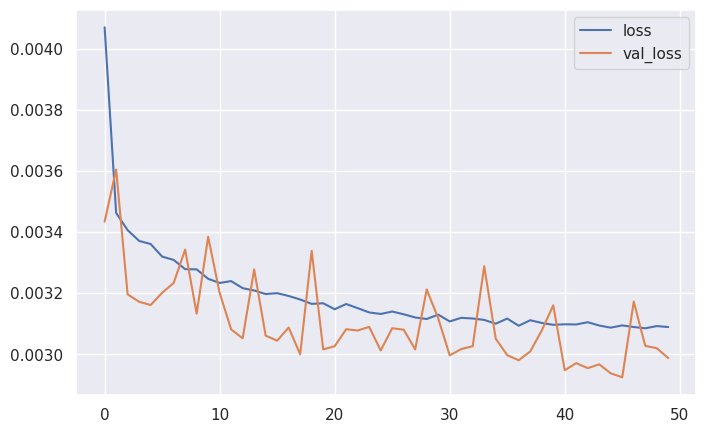

In [12]:
pd.DataFrame(history.history).plot(figsize=(8, 5))